# Participation to co-creation: tools and methods for the involvement of stakeholders in mobility planning in Germany

#### Libraries

In [1]:
# loading libraries
import pandas as pd
from ast import literal_eval
import itertools
from apyori import apriori
import networkx as nx  
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots
from networkx.algorithms import community

#### Functions

In [2]:
# function to calculate intersections between two lists
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [3]:
# function to concatenate three lists in all possible combinations
def concatenation(lst1, lst2, lst3):
    a = [lst1, lst2, lst3]
    return list(itertools.product(*a))

#### Data import / preparation

In [4]:
df = pd.read_csv("SUMP_codes_clean.csv", index_col=0)
df.head()

,Number,Merge,Text Content,Document,Codes,id
0,1:1,1,involvement and participation of citizens and ...,Aachen-SUMP-Partizipation-2016.pdf,"citizens and wider public, increase user accep...",Aachen-SUMP-Partizipation-2016.pdf_1
1,1:2,1,"Aachen (Germany), Gdynia (Poland), Koprivnica ...",Aachen-SUMP-Partizipation-2016.pdf,"increase user acceptance / legitimacy, online_...",Aachen-SUMP-Partizipation-2016.pdf_1
2,1:4,2,The involvement of citizens obliges transport ...,Aachen-SUMP-Partizipation-2016.pdf,citizens and wider public,Aachen-SUMP-Partizipation-2016.pdf_2
3,1:5,2,This is a good example of how projects “coming...,Aachen-SUMP-Partizipation-2016.pdf,"increase user acceptance / legitimacy,",Aachen-SUMP-Partizipation-2016.pdf_2
4,1:6,2,A mobility vision for the year 2050 in Aachen ...,Aachen-SUMP-Partizipation-2016.pdf,"decision-makers / political authorities, envis...",Aachen-SUMP-Partizipation-2016.pdf_2


In [5]:
df.shape

(272, 6)

In [6]:
# create 3 list with the main categories: Target groups
# annotation: In order to facilitate the string comparison,
# the target group "decision-makers, political authorities" has been changed to "decision-makers / political authorities"
target_groups_list = ["social organisations / public interest groups", "young and children", "users",
                      "senior citizens", "citizens and wider public", "multiplicators",
                      "transport providers and operators / public services like energy", "non defined stakeholders",
                      "researchers", "regional actors", "private business / economy", "political actors / district committees",
                      "networks and associations", "municipal employees / members of the public administration",
                      "experts-practitioners-planers", "decision-makers / political authorities",
                      "Committees representing public interests", "consultants"]

In [7]:
# create 3 list with the main categories: Methods
# annotations: In order to facilitate the string comparison,
# the method online questionnaire/ survey has been changed to online_questionnaire_survey
methods_list = ["co-creation workshop", "meetings", "working group", "stakeholder workshops", "visualisation methods", "round table", "scenario development", "citizen workshop / citizen forum", "advisory board", "focus group", "interviews", "survey", "expert forum / expert workshop", "city walks / city tours", "citizen contest", "conferences / symposium", "stalls / market fairs", "exhibition / event / presentation", "press / marketing / public relations / communication", "online public events", "social networks", "online platform", "online_questionnaire_zurvey", "online communication"]

In [8]:
# create 3 list with the main categories: Goals
goals_list = ["communication / transparency", "envisioning / common ground", "feedback / discussion", "ideation / innovation", "increase user acceptance / legitimacy", "project management", "understand users / user behavior / requirements"]

In [9]:
# since a single activity is splitted in multiple text blocks, groupby following the id column
df = df.groupby(['id'])['Codes'].apply(lambda x: ','.join(x)).reset_index()
df.head()

,id,Codes
0,Aachen-SUMP-Partizipation-2016.pdf_1,"citizens and wider public, increase user accep..."
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept..."
2,Aachen-SUMP-Partizipation-2016.pdf_3,"citizen workshop / citizen forum, citizens and..."
3,Aachen-SUMP-Partizipation-2016.pdf_4,"citizens and wider public, feedback / discussi..."
4,Aachen-SUMP-Partizipation-2016.pdf_5,"citizens and wider public, communication / tra..."


In [10]:
# check if the codes contains at least one target group
found = [df['Codes'].str.contains(x) for x in target_groups_list]
result = pd.DataFrame(found)
result_t = result.T
result_t['contains_a_target_group'] = result_t.any(axis = 1)
df['contains_a_target_group'] = result_t['contains_a_target_group']  

# check if the codes contains at least one method
found = [df['Codes'].str.contains(x) for x in methods_list]
result = pd.DataFrame(found)
result_t = result.T
result_t['contains_a_method'] = result_t.any(axis = 1)
df['contains_a_method'] = result_t['contains_a_method']

# check if the codes contains at least one goal
found = [df['Codes'].str.contains(x) for x in goals_list]
result = pd.DataFrame(found)
result_t = result.T
result_t['contains_a_goal'] = result_t.any(axis = 1)
df['contains_a_goal'] = result_t['contains_a_goal']

# check if at least one of methods and target groups is missing
df['all_three_present'] = df[['contains_a_method', 'contains_a_target_group', 'contains_a_goal']].all(axis=1)

# remove rows the all_three_present is not true
df = df[df['all_three_present'] == True]
df.head()

,id,Codes,contains_a_target_group,contains_a_method,contains_a_goal,all_three_present
0,Aachen-SUMP-Partizipation-2016.pdf_1,"citizens and wider public, increase user accep...",True,True,True,True
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept...",True,True,True,True
2,Aachen-SUMP-Partizipation-2016.pdf_3,"citizen workshop / citizen forum, citizens and...",True,True,True,True
3,Aachen-SUMP-Partizipation-2016.pdf_4,"citizens and wider public, feedback / discussi...",True,True,True,True
4,Aachen-SUMP-Partizipation-2016.pdf_5,"citizens and wider public, communication / tra...",True,True,True,True


In [11]:
# How many activities do we have in the dataset?
df.shape

(176, 6)

In [12]:
# apply function in order to intersecate list of goals, methods and target groups with codes and separate them
# methods
df['Methods_applied'] = df.apply(lambda row: intersection(methods_list,row['Codes']),axis=1)

# target groups
df['Target_groups_involved'] = df.apply(lambda row: intersection(target_groups_list,row['Codes']),axis=1)

# goals
df['Goals_pursued'] = df.apply(lambda row: intersection(goals_list,row['Codes']),axis=1)
df.head()

,id,Codes,contains_a_target_group,contains_a_method,contains_a_goal,all_three_present,Methods_applied,Target_groups_involved,Goals_pursued
0,Aachen-SUMP-Partizipation-2016.pdf_1,"citizens and wider public, increase user accep...",True,True,True,True,[online_questionnaire_zurvey],"[citizens and wider public, non defined stakeh...",[increase user acceptance / legitimacy]
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept...",True,True,True,True,[scenario development],"[citizens and wider public, non defined stakeh...","[envisioning / common ground, increase user ac..."
2,Aachen-SUMP-Partizipation-2016.pdf_3,"citizen workshop / citizen forum, citizens and...",True,True,True,True,"[visualisation methods, scenario development, ...",[citizens and wider public],[feedback / discussion]
3,Aachen-SUMP-Partizipation-2016.pdf_4,"citizens and wider public, feedback / discussi...",True,True,True,True,[online_questionnaire_zurvey],[citizens and wider public],[feedback / discussion]
4,Aachen-SUMP-Partizipation-2016.pdf_5,"citizens and wider public, communication / tra...",True,True,True,True,[online communication],[citizens and wider public],[communication / transparency]


In [13]:
# apply the concatenation function in order to create a list of lists combining target groups, methods and goals
df['list_of_concepts'] = df.apply(lambda row: concatenation(row['Target_groups_involved'], row['Methods_applied'], row['Goals_pursued']),axis=1)
df.head()

,id,Codes,contains_a_target_group,contains_a_method,contains_a_goal,all_three_present,Methods_applied,Target_groups_involved,Goals_pursued,list_of_concepts
0,Aachen-SUMP-Partizipation-2016.pdf_1,"citizens and wider public, increase user accep...",True,True,True,True,[online_questionnaire_zurvey],"[citizens and wider public, non defined stakeh...",[increase user acceptance / legitimacy],"[(citizens and wider public, online_questionna..."
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept...",True,True,True,True,[scenario development],"[citizens and wider public, non defined stakeh...","[envisioning / common ground, increase user ac...","[(citizens and wider public, scenario developm..."
2,Aachen-SUMP-Partizipation-2016.pdf_3,"citizen workshop / citizen forum, citizens and...",True,True,True,True,"[visualisation methods, scenario development, ...",[citizens and wider public],[feedback / discussion],"[(citizens and wider public, visualisation met..."
3,Aachen-SUMP-Partizipation-2016.pdf_4,"citizens and wider public, feedback / discussi...",True,True,True,True,[online_questionnaire_zurvey],[citizens and wider public],[feedback / discussion],"[(citizens and wider public, online_questionna..."
4,Aachen-SUMP-Partizipation-2016.pdf_5,"citizens and wider public, communication / tra...",True,True,True,True,[online communication],[citizens and wider public],[communication / transparency],"[(citizens and wider public, online communicat..."


In [14]:
# create a short df with only the relevant variables
df_short = df[['id', 'Codes','list_of_concepts']]
# explode the list of concepts
df_short = df_short.explode('list_of_concepts')
# rename cols in a friendly way
df_short = df_short.rename(columns={"Codes": "all_original_codes", "list_of_concepts": "TG_M_G"})
df_short.head()

,id,all_original_codes,TG_M_G
0,Aachen-SUMP-Partizipation-2016.pdf_1,"citizens and wider public, increase user accep...","(citizens and wider public, online_questionnai..."
0,Aachen-SUMP-Partizipation-2016.pdf_1,"citizens and wider public, increase user accep...","(non defined stakeholders, online_questionnair..."
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept...","(citizens and wider public, scenario developme..."
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept...","(citizens and wider public, scenario developme..."
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept...","(non defined stakeholders, scenario developmen..."


In [15]:
#  By combining goals, target groups and methods, how many associations do we have in the dataset?
df_short.shape

(467, 3)

In [16]:
# calculate stats about the associations TG_M_G
stats = df_short.groupby(['TG_M_G']).size().reset_index(name='counts')
stats.sort_values(by = "counts", ascending=False).head(10)

,TG_M_G,counts
28,"(citizens and wider public, citizen workshop /...",22
37,"(citizens and wider public, online communicati...",12
127,(municipal employees / members of the public a...,10
41,"(citizens and wider public, online platform, f...",8
46,"(citizens and wider public, press / marketing ...",8
26,"(citizens and wider public, citizen workshop /...",6
34,"(citizens and wider public, exhibition / event...",6
35,"(citizens and wider public, exhibition / event...",6
126,(municipal employees / members of the public a...,6
47,"(citizens and wider public, press / marketing ...",6


In [17]:
# How many unique associations do we have in the dataset? 
stats.shape

(256, 2)

In [18]:
# transform the list to string
df_short['TG_M_G_string'] = df_short['TG_M_G'].astype(str)
df_short.head()

,id,all_original_codes,TG_M_G,TG_M_G_string
0,Aachen-SUMP-Partizipation-2016.pdf_1,"citizens and wider public, increase user accep...","(citizens and wider public, online_questionnai...","('citizens and wider public', 'online_question..."
0,Aachen-SUMP-Partizipation-2016.pdf_1,"citizens and wider public, increase user accep...","(non defined stakeholders, online_questionnair...","('non defined stakeholders', 'online_questionn..."
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept...","(citizens and wider public, scenario developme...","('citizens and wider public', 'scenario develo..."
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept...","(citizens and wider public, scenario developme...","('citizens and wider public', 'scenario develo..."
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept...","(non defined stakeholders, scenario developmen...","('non defined stakeholders', 'scenario develop..."


In [19]:
# manipulate the string
df_short['TG_M_G_string'] = df_short['TG_M_G_string'].str.replace("(", '', regex=False, case = True)
df_short['TG_M_G_string'] = df_short['TG_M_G_string'].str.replace(")", '', regex=False, case = True)
df_short['TG_M_G_string'] = df_short['TG_M_G_string'].str.replace("'", '', regex=False, case = True)
df_short['TG_M_G_string'] = df_short['TG_M_G_string'].str.replace("', ", "',", regex=False, case = True)
df_short.head()

,id,all_original_codes,TG_M_G,TG_M_G_string
0,Aachen-SUMP-Partizipation-2016.pdf_1,"citizens and wider public, increase user accep...","(citizens and wider public, online_questionnai...","citizens and wider public, online_questionnair..."
0,Aachen-SUMP-Partizipation-2016.pdf_1,"citizens and wider public, increase user accep...","(non defined stakeholders, online_questionnair...","non defined stakeholders, online_questionnaire..."
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept...","(citizens and wider public, scenario developme...","citizens and wider public, scenario developmen..."
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept...","(citizens and wider public, scenario developme...","citizens and wider public, scenario developmen..."
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept...","(non defined stakeholders, scenario developmen...","non defined stakeholders, scenario development..."


In [20]:
# enumerate how many processes per sump
df_short['city'] = df['id'].str.split('.pdf|.PDF|.docx').str[0]
df_short['activity'] = df['id'].str.split('.pdf|.PDF|.docx').str[1]
df_short['activity'] = df_short['activity'].str.replace('_',"", regex=False)
df_cities = df_short[['city', 'activity']]

In [21]:
# take the highest n as the number of activities in the city
activities_by_city = df_cities.groupby('city').max()

In [22]:
# inspect cities with highest n of activities
activities_by_city.sort_values(by = "activity", ascending=False).head(10)

,activity
city,
Bremen-sump-2012,9
Hildesheim-GreenCityPlan-2018,9
Flensburg-Mobilitätsplan-2017,8
Kassell-Sump-2018,8
Leipzig -SUMP-2015,7
Bremen-SUMP-2014,7
Guetersloh-Masterplan_klima-Mobilitaet-2017,7
Saarbrücken_VEP-2016,6
Chemnitz_beteiligungskonzept-2020,6


In [23]:
# inspect cities with lowest n of activities
activities_by_city.sort_values(by = "activity", ascending=True).head(10)

,activity
city,
Pforzheim 2020-VEP,1
Mannheim-Beteiligung-2021,1
Ingolstadt-Beteiligung-2016,1
Halle-Stadtmobilitätsplan-2018,1
Trier-sump-kurzfassung-2013,1
Erfurt-Teilkonzept-2015,1
Fröndeberg-VEP-2015,1
Oldenburg-Strategie-2014,1
Wolfsburg-Mobilitätsstrategie-2020,1


In [24]:
# Split the code column in a column for tg, one for m and one for g
df_rules = pd.concat([df_short, df_short.TG_M_G_string.str.split(",", expand=True)], axis=1)
df_rules.head()

,id,all_original_codes,TG_M_G,TG_M_G_string,city,activity,0,1,2
0,Aachen-SUMP-Partizipation-2016.pdf_1,"citizens and wider public, increase user accep...","(citizens and wider public, online_questionnai...","citizens and wider public, online_questionnair...",Aachen-SUMP-Partizipation-2016,1,citizens and wider public,online_questionnaire_zurvey,increase user acceptance / legitimacy
0,Aachen-SUMP-Partizipation-2016.pdf_1,"citizens and wider public, increase user accep...","(non defined stakeholders, online_questionnair...","non defined stakeholders, online_questionnaire...",Aachen-SUMP-Partizipation-2016,1,non defined stakeholders,online_questionnaire_zurvey,increase user acceptance / legitimacy
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept...","(citizens and wider public, scenario developme...","citizens and wider public, scenario developmen...",Aachen-SUMP-Partizipation-2016,2,citizens and wider public,scenario development,envisioning / common ground
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept...","(citizens and wider public, scenario developme...","citizens and wider public, scenario developmen...",Aachen-SUMP-Partizipation-2016,2,citizens and wider public,scenario development,increase user acceptance / legitimacy
1,Aachen-SUMP-Partizipation-2016.pdf_2,"citizens and wider public,increase user accept...","(non defined stakeholders, scenario developmen...","non defined stakeholders, scenario development...",Aachen-SUMP-Partizipation-2016,2,non defined stakeholders,scenario development,envisioning / common ground


In [25]:
# create a friendly df for the analysis at concept level and rename cols
df_rules = df_rules[[0, 1, 2]]
df_rules = df_rules.rename(columns={0: "TG", 1: "M", 2: "G"})

df_rules.G = df_rules.G.str.lstrip()
df_rules.TG = df_rules.TG.str.lstrip()
df_rules.M = df_rules.M.str.lstrip()
df_rules.head()

,TG,M,G
0,citizens and wider public,online_questionnaire_zurvey,increase user acceptance / legitimacy
0,non defined stakeholders,online_questionnaire_zurvey,increase user acceptance / legitimacy
1,citizens and wider public,scenario development,envisioning / common ground
1,citizens and wider public,scenario development,increase user acceptance / legitimacy
1,non defined stakeholders,scenario development,envisioning / common ground


### Visualize Heatmaps by combining two dimensions

#### Compare target groups and goals

In [26]:
# group by to count the n of unique associations
count_series = df_rules.groupby(['TG', 'G']).size()

# transform to df
heatmap_df_tg_g = count_series.to_frame(name = 'size').reset_index()
heatmap_df_tg_g.head()

,TG,G,size
0,Committees representing public interests,communication / transparency,7
1,Committees representing public interests,envisioning / common ground,4
2,Committees representing public interests,feedback / discussion,15
3,Committees representing public interests,ideation / innovation,3
4,Committees representing public interests,increase user acceptance / legitimacy,1


In [27]:
# match with the SUMP phases
phase_2_list = ["envisioning / common ground", "ideation / innovation", "understand users / user behavior / requirements"]
phase_3_list = ["communication / transparency", "feedback / discussion", "increase user acceptance / legitimacy"]
meta_level_list = ["project management"]

heatmap_df_tg_g["Phase"] = np.where(heatmap_df_tg_g["G"].isin(phase_2_list), "Phase 2",
                             (np.where(heatmap_df_tg_g["G"].isin(phase_3_list), "Phase 4",
                                       (np.where(heatmap_df_tg_g["G"].isin(meta_level_list), "Meta", 'Other')))))

heatmap_df_tg_g["G"] = heatmap_df_tg_g["Phase"] + " - " + heatmap_df_tg_g["G"] 
heatmap_df_tg_g.head(25)

,TG,G,size,Phase
0,Committees representing public interests,Phase 4 - communication / transparency,7,Phase 4
1,Committees representing public interests,Phase 2 - envisioning / common ground,4,Phase 2
2,Committees representing public interests,Phase 4 - feedback / discussion,15,Phase 4
3,Committees representing public interests,Phase 2 - ideation / innovation,3,Phase 2
4,Committees representing public interests,Phase 4 - increase user acceptance / legitimacy,1,Phase 4
5,Committees representing public interests,Meta - project management,2,Meta
6,Committees representing public interests,Phase 2 - understand users / user behavior / r...,2,Phase 2
7,citizens and wider public,Phase 4 - communication / transparency,40,Phase 4
8,citizens and wider public,Phase 2 - envisioning / common ground,11,Phase 2
9,citizens and wider public,Phase 4 - feedback / discussion,51,Phase 4


In [28]:
# match with the macro categories for target groups
citizens_list = ["young and children", "users", "senior citizens", "citizens and wider public", "multiplicators"]
civil_society_list = ["social organisations / public interest groups", "networks and associations", "Committees representing public interests"]
politic_administration_list = ["regional actors", "political actors / district committees", "municipal employees / members of the public administration", "experts-practitioners-planers", "decision-makers / political authorities"]
economy_list = ["transport providers and operators / public services like energy", "private business / economy", "consultants"]
further_stakeholders_list = ["non defined stakeholders", "researchers"]

heatmap_df_tg_g["Macro_TG"] = np.where(heatmap_df_tg_g["TG"].isin(citizens_list), "Citizens",
                                      (np.where(heatmap_df_tg_g["TG"].isin(civil_society_list), "Civil society",
                                           (np.where(heatmap_df_tg_g["TG"].isin(politic_administration_list), "Politics & administration",
                                               (np.where(heatmap_df_tg_g["TG"].isin(economy_list), "Economy",
                                                   (np.where(heatmap_df_tg_g["TG"].isin(further_stakeholders_list), "Further stakeholder groups", 'Other')))))))))

# create friendly string
heatmap_df_tg_g["TG"] = heatmap_df_tg_g["Macro_TG"] + " - " + heatmap_df_tg_g["TG"]
heatmap_df_tg_g.head(25)

,TG,G,size,Phase,Macro_TG
0,Civil society - Committees representing public...,Phase 4 - communication / transparency,7,Phase 4,Civil society
1,Civil society - Committees representing public...,Phase 2 - envisioning / common ground,4,Phase 2,Civil society
2,Civil society - Committees representing public...,Phase 4 - feedback / discussion,15,Phase 4,Civil society
3,Civil society - Committees representing public...,Phase 2 - ideation / innovation,3,Phase 2,Civil society
4,Civil society - Committees representing public...,Phase 4 - increase user acceptance / legitimacy,1,Phase 4,Civil society
5,Civil society - Committees representing public...,Meta - project management,2,Meta,Civil society
6,Civil society - Committees representing public...,Phase 2 - understand users / user behavior / r...,2,Phase 2,Civil society
7,Citizens - citizens and wider public,Phase 4 - communication / transparency,40,Phase 4,Citizens
8,Citizens - citizens and wider public,Phase 2 - envisioning / common ground,11,Phase 2,Citizens
9,Citizens - citizens and wider public,Phase 4 - feedback / discussion,51,Phase 4,Citizens


In [29]:
# reduce the df
heatmap_df_tg_g = heatmap_df_tg_g[['TG', 'G', 'size']]

# transform to a matrix
heatmap_df_tg_g = heatmap_df_tg_g.pivot(index='TG', columns='G', values='size')

# sort by phases
heatmap_df_tg_g = heatmap_df_tg_g.reindex(sorted(heatmap_df_tg_g.columns), axis=1)

# replace nas
heatmap_df_tg_g = heatmap_df_tg_g.fillna(0)
heatmap_df_tg_g.head()

G,Meta - project management,Phase 2 - envisioning / common ground,Phase 2 - ideation / innovation,Phase 2 - understand users / user behavior / requirements,Phase 4 - communication / transparency,Phase 4 - feedback / discussion,Phase 4 - increase user acceptance / legitimacy
TG,,,,,,,
Citizens - citizens and wider public,0.0,11.0,13.0,2.0,40.0,51.0,14.0
Citizens - multiplicators,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Citizens - senior citizens,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Citizens - users,0.0,1.0,0.0,7.0,0.0,4.0,0.0
Citizens - young and children,0.0,0.0,0.0,1.0,1.0,3.0,0.0


In [30]:
# create an annoted heatmap
fig = ff.create_annotated_heatmap(heatmap_df_tg_g.values.tolist(),
                                  x=heatmap_df_tg_g.columns.values.tolist(),
                                  y=heatmap_df_tg_g.index.values.tolist(),
                                  colorscale='Reds')
# axis and title text
fig.update_layout(title_text='Target groups Vs Goals', yaxis_title='Target groups', xaxis_title='Goals')

# move xaxis on top
fig.update_xaxes(side="top")

# adjust positioning
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
)
)
fig.write_html('first_figure_tg_g.html', auto_open=True)

#### Compare methods and goals

In [31]:
# group by to count the n of unique associations
count_series = df_rules.groupby(['M', 'G']).size()

# transform to df
heatmap_df_m_g = count_series.to_frame(name = 'size').reset_index()
heatmap_df_m_g.head()

,M,G,size
0,advisory board,envisioning / common ground,9
1,advisory board,feedback / discussion,9
2,advisory board,increase user acceptance / legitimacy,5
3,advisory board,project management,10
4,citizen contest,ideation / innovation,1


In [32]:
# match with the SUMP phases
phase_2_list = ["envisioning / common ground", "ideation / innovation", "understand users / user behavior / requirements"]
phase_3_list = ["communication / transparency", "feedback / discussion", "increase user acceptance / legitimacy"]
meta_level_list = ["project management"]

heatmap_df_m_g["Phase"] = np.where(heatmap_df_m_g["G"].isin(phase_2_list), "Phase 2",
                             (np.where(heatmap_df_m_g["G"].isin(phase_3_list), "Phase 4",
                                       (np.where(heatmap_df_m_g["G"].isin(meta_level_list), "Meta", 'Other')))))

heatmap_df_m_g["G"] = heatmap_df_m_g["Phase"] + " - " + heatmap_df_m_g["G"] 
heatmap_df_m_g.head(25)

,M,G,size,Phase
0,advisory board,Phase 2 - envisioning / common ground,9,Phase 2
1,advisory board,Phase 4 - feedback / discussion,9,Phase 4
2,advisory board,Phase 4 - increase user acceptance / legitimacy,5,Phase 4
3,advisory board,Meta - project management,10,Meta
4,citizen contest,Phase 2 - ideation / innovation,1,Phase 2
5,citizen workshop / citizen forum,Phase 4 - communication / transparency,9,Phase 4
6,citizen workshop / citizen forum,Phase 2 - envisioning / common ground,5,Phase 2
7,citizen workshop / citizen forum,Phase 4 - feedback / discussion,33,Phase 4
8,citizen workshop / citizen forum,Phase 2 - ideation / innovation,6,Phase 2
9,citizen workshop / citizen forum,Phase 4 - increase user acceptance / legitimacy,4,Phase 4


In [33]:
# match with macro methods
pw_ws_list = ["co-creation workshop", "meetings", "working group", "stakeholder workshops", "visualisation methods", "round table", "scenario development", "citizen workshop / citizen forum"]
consultation_list = ["advisory board", "focus group", "interviews", "survey", "expert forum / expert workshop"]
public_events_list = ["city walks / city tours", "citizen contest", "conferences / symposium", "stalls / market fairs", "exhibition / event / presentation", "press / marketing / public relations / communication"]
online_participation_list = ["online public events", "social networks", "online platform", "online_questionnaire_zurvey", "online communication"]

heatmap_df_m_g["Macro_M"] = np.where(heatmap_df_m_g["M"].isin(pw_ws_list), "Participation Workshops Series",
                                    (np.where(heatmap_df_m_g["M"].isin(consultation_list), "Consultation",
                                              (np.where(heatmap_df_m_g["M"].isin(public_events_list), "Public events",
                                                        (np.where(heatmap_df_m_g["M"].isin(online_participation_list), "Online Particpation", 'Other')))))))

heatmap_df_m_g["M"] = heatmap_df_m_g["Macro_M"] + " - " + heatmap_df_m_g["M"]
heatmap_df_m_g.head(25)

,M,G,size,Phase,Macro_M
0,Consultation - advisory board,Phase 2 - envisioning / common ground,9,Phase 2,Consultation
1,Consultation - advisory board,Phase 4 - feedback / discussion,9,Phase 4,Consultation
2,Consultation - advisory board,Phase 4 - increase user acceptance / legitimacy,5,Phase 4,Consultation
3,Consultation - advisory board,Meta - project management,10,Meta,Consultation
4,Public events - citizen contest,Phase 2 - ideation / innovation,1,Phase 2,Public events
5,Participation Workshops Series - citizen works...,Phase 4 - communication / transparency,9,Phase 4,Participation Workshops Series
6,Participation Workshops Series - citizen works...,Phase 2 - envisioning / common ground,5,Phase 2,Participation Workshops Series
7,Participation Workshops Series - citizen works...,Phase 4 - feedback / discussion,33,Phase 4,Participation Workshops Series
8,Participation Workshops Series - citizen works...,Phase 2 - ideation / innovation,6,Phase 2,Participation Workshops Series
9,Participation Workshops Series - citizen works...,Phase 4 - increase user acceptance / legitimacy,4,Phase 4,Participation Workshops Series


In [34]:
# reduce the df
heatmap_df_m_g = heatmap_df_m_g[['M', 'G', 'size']]

# transform to a matrix
heatmap_df_m_g = heatmap_df_m_g.pivot(index='M', columns='G', values='size')

# sort by phases
heatmap_df_m_g = heatmap_df_m_g.reindex(sorted(heatmap_df_m_g.columns), axis=1)

# replace nas
heatmap_df_m_g = heatmap_df_m_g.fillna(0)
heatmap_df_m_g.head()

G,Meta - project management,Phase 2 - envisioning / common ground,Phase 2 - ideation / innovation,Phase 2 - understand users / user behavior / requirements,Phase 4 - communication / transparency,Phase 4 - feedback / discussion,Phase 4 - increase user acceptance / legitimacy
M,,,,,,,
Consultation - advisory board,10.0,9.0,0.0,0.0,0.0,9.0,5.0
Consultation - expert forum / expert workshop,0.0,5.0,1.0,0.0,3.0,15.0,0.0
Consultation - focus group,0.0,2.0,0.0,0.0,0.0,0.0,0.0
Consultation - interviews,0.0,0.0,0.0,12.0,0.0,21.0,0.0
Consultation - survey,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [35]:
# create an annotated heatmap
fig = ff.create_annotated_heatmap(heatmap_df_m_g.values.tolist(),
                                  x=heatmap_df_m_g.columns.values.tolist(),
                                  y=heatmap_df_m_g.index.values.tolist(),
                                  colorscale='Reds')

# axis and title text
fig.update_layout(title_text='Methods Vs Goals', yaxis_title='Methods', xaxis_title='Goals')

# move xaxis on top
fig.update_xaxes(side="top")

# adjust positioning
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
)
)
fig.write_html('first_figure_m_g.html', auto_open=True)

#### Compare target groups and methods

In [36]:
# group by to count the n of unique associations
count_series = df_rules.groupby(['TG', 'M']).size()

# transform to df
heatmap_df_tg_m = count_series.to_frame(name = 'size').reset_index()
heatmap_df_tg_m.head()

,TG,M,size
0,Committees representing public interests,advisory board,3
1,Committees representing public interests,citizen workshop / citizen forum,4
2,Committees representing public interests,conferences / symposium,3
3,Committees representing public interests,exhibition / event / presentation,1
4,Committees representing public interests,expert forum / expert workshop,2


In [37]:
# match with macro methods
pw_ws_list = ["co-creation workshop", "meetings", "working group", "stakeholder workshops", "visualisation methods", "round table", "scenario development", "citizen workshop / citizen forum"]
consultation_list = ["advisory board", "focus group", "interviews", "survey", "expert forum / expert workshop"]
public_events_list = ["city walks / city tours", "citizen contest", "conferences / symposium", "stalls / market fairs", "exhibition / event / presentation", "press / marketing / public relations / communication"]
online_participation_list = ["online public events", "social networks", "online platform", "online_questionnaire_zurvey", "online communication"]

heatmap_df_tg_m["Macro_M"] = np.where(heatmap_df_tg_m["M"].isin(pw_ws_list), "Participation Workshops Series",
                                    (np.where(heatmap_df_tg_m["M"].isin(consultation_list), "Consultation",
                                              (np.where(heatmap_df_tg_m["M"].isin(public_events_list), "Public events",
                                                        (np.where(heatmap_df_tg_m["M"].isin(online_participation_list), "Online Particpation", 'Other')))))))

heatmap_df_tg_m["M"] = heatmap_df_tg_m["Macro_M"] + " - " + heatmap_df_tg_m["M"]
heatmap_df_tg_m.head(25)

,TG,M,size,Macro_M
0,Committees representing public interests,Consultation - advisory board,3,Consultation
1,Committees representing public interests,Participation Workshops Series - citizen works...,4,Participation Workshops Series
2,Committees representing public interests,Public events - conferences / symposium,3,Public events
3,Committees representing public interests,Public events - exhibition / event / presentation,1,Public events
4,Committees representing public interests,Consultation - expert forum / expert workshop,2,Consultation
5,Committees representing public interests,Consultation - interviews,2,Consultation
6,Committees representing public interests,Online Particpation - online communication,2,Online Particpation
7,Committees representing public interests,Public events - press / marketing / public rel...,1,Public events
8,Committees representing public interests,Participation Workshops Series - round table,5,Participation Workshops Series
9,Committees representing public interests,Online Particpation - social networks,2,Online Particpation


In [38]:
# match with the macro categories for target groups
citizens_list = ["young and children", "users", "senior citizens", "citizens and wider public", "multiplicators"]
civil_society_list = ["social organisations / public interest groups", "networks and associations", "Committees representing public interests"]
politic_administration_list = ["regional actors", "political actors / district committees", "municipal employees / members of the public administration", "experts-practitioners-planers", "decision-makers / political authorities"]
economy_list = ["transport providers and operators / public services like energy", "private business / economy", "consultants"]
further_stakeholders_list = ["non defined stakeholders", "researchers"]

heatmap_df_tg_m["Macro_TG"] = np.where(heatmap_df_tg_m["TG"].isin(citizens_list), "Citizens",
                                      (np.where(heatmap_df_tg_m["TG"].isin(civil_society_list), "Civil society",
                                           (np.where(heatmap_df_tg_m["TG"].isin(politic_administration_list), "Politics & administration",
                                               (np.where(heatmap_df_tg_m["TG"].isin(economy_list), "Economy",
                                                   (np.where(heatmap_df_tg_m["TG"].isin(further_stakeholders_list), "Further stakeholder groups", 'Other')))))))))

# create friendly string
heatmap_df_tg_m["TG"] = heatmap_df_tg_m["Macro_TG"] + " - " + heatmap_df_tg_m["TG"]
heatmap_df_tg_m.head(25)

,TG,M,size,Macro_M,Macro_TG
0,Civil society - Committees representing public...,Consultation - advisory board,3,Consultation,Civil society
1,Civil society - Committees representing public...,Participation Workshops Series - citizen works...,4,Participation Workshops Series,Civil society
2,Civil society - Committees representing public...,Public events - conferences / symposium,3,Public events,Civil society
3,Civil society - Committees representing public...,Public events - exhibition / event / presentation,1,Public events,Civil society
4,Civil society - Committees representing public...,Consultation - expert forum / expert workshop,2,Consultation,Civil society
5,Civil society - Committees representing public...,Consultation - interviews,2,Consultation,Civil society
6,Civil society - Committees representing public...,Online Particpation - online communication,2,Online Particpation,Civil society
7,Civil society - Committees representing public...,Public events - press / marketing / public rel...,1,Public events,Civil society
8,Civil society - Committees representing public...,Participation Workshops Series - round table,5,Participation Workshops Series,Civil society
9,Civil society - Committees representing public...,Online Particpation - social networks,2,Online Particpation,Civil society


In [39]:
# reduce the df
heatmap_df_tg_m = heatmap_df_tg_m[['TG', 'M', 'size']]

# transform to a matrix
heatmap_df_tg_m = heatmap_df_tg_m.pivot(index='TG', columns='M', values='size')

# sort by phases
heatmap_df_tg_m = heatmap_df_tg_m.reindex(sorted(heatmap_df_tg_m.columns), axis=1)

# replace nas
heatmap_df_tg_m = heatmap_df_tg_m.fillna(0)
heatmap_df_tg_m.head()

M,Consultation - advisory board,Consultation - expert forum / expert workshop,Consultation - focus group,Consultation - interviews,Consultation - survey,Online Particpation - online communication,Online Particpation - online platform,Online Particpation - online_questionnaire_zurvey,Online Particpation - social networks,Participation Workshops Series - citizen workshop / citizen forum,...,Participation Workshops Series - scenario development,Participation Workshops Series - stakeholder workshops,Participation Workshops Series - visualisation methods,Participation Workshops Series - working group,Public events - citizen contest,Public events - city walks / city tours,Public events - conferences / symposium,Public events - exhibition / event / presentation,Public events - press / marketing / public relations / communication,Public events - stalls / market fairs
TG,,,,,,,,,,,,,,,,,,,,,
Citizens - citizens and wider public,0.0,0.0,2.0,0.0,0.0,18.0,12.0,3.0,3.0,43.0,...,8.0,0.0,1.0,3.0,1.0,7.0,0.0,12.0,14.0,3.0
Citizens - multiplicators,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Citizens - senior citizens,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Citizens - users,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Citizens - young and children,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# create an annotated heatmap
fig = ff.create_annotated_heatmap(heatmap_df_tg_m.values.tolist(),
                                  x=heatmap_df_tg_m.columns.values.tolist(),
                                  y=heatmap_df_tg_m.index.values.tolist(),
                                  colorscale='Reds')

# axis and title text
fig.update_layout(title_text='Target groups Vs Methods', yaxis_title='Target groups', xaxis_title='Methods')

# move xaxis on top
fig.update_xaxes(side="top")

# adjust positioning
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
)
)
fig.write_html('first_figure_m_g.html', auto_open=True)

### Association rules

#### Applying the Apyori algorithm

In [41]:
# create a list of list
processes = []
for i in range(0, 467):
    processes.append([str(df_rules.values[i,j]) for j in range(0, 3)])
processes

[['citizens and wider public',
  'online_questionnaire_zurvey',
  'increase user acceptance / legitimacy'],
 ['non defined stakeholders',
  'online_questionnaire_zurvey',
  'increase user acceptance / legitimacy'],
 ['citizens and wider public',
  'scenario development',
  'envisioning / common ground'],
 ['citizens and wider public',
  'scenario development',
  'increase user acceptance / legitimacy'],
 ['non defined stakeholders',
  'scenario development',
  'envisioning / common ground'],
 ['non defined stakeholders',
  'scenario development',
  'increase user acceptance / legitimacy'],
 ['decision-makers / political authorities',
  'scenario development',
  'envisioning / common ground'],
 ['decision-makers / political authorities',
  'scenario development',
  'increase user acceptance / legitimacy'],
 ['citizens and wider public',
  'visualisation methods',
  'feedback / discussion'],
 ['citizens and wider public',
  'scenario development',
  'feedback / discussion'],
 ['citizens 

In [42]:
# Set the parameters
# min_support > the rule has to appear a minimum amount of time > 3 > hence: 3 / 467 = 0.006 
min_appearence_of_the_rule = 3
support = min_appearence_of_the_rule / len(df_rules)

In [43]:
# Training the Apriori model on the dataset
rules = apriori(processes, min_support = support, min_confidence = 0.3, max_length = 3)

# save the results as list
results = list(rules)

In [44]:
# Visualising the results in friendly way as a dataframe
associations_df = pd.DataFrame(columns=('Items','Antecedent','Consequent','Support','Confidence','Lift'))

Support =[]
Confidence = []
Lift = []
Items = []
Antecedent = []
Consequent=[]

for RelationRecord in results:
    for ordered_stat in RelationRecord.ordered_statistics:
        Support.append(RelationRecord.support)
        Items.append(RelationRecord.items)
        Antecedent.append(ordered_stat.items_base)
        Consequent.append(ordered_stat.items_add)
        Confidence.append(ordered_stat.confidence)
        Lift.append(ordered_stat.lift)

associations_df['Items'] = list(map(set, Items))                                   
associations_df['Antecedent'] = list(map(set, Antecedent))
associations_df['Consequent'] = list(map(set, Consequent))
associations_df['Support'] = Support
associations_df['Confidence'] = Confidence
associations_df['Lift']= Lift

associations_df = associations_df.sort_values("Lift", axis=0, ascending=False)
associations_df.head()

,Items,Antecedent,Consequent,Support,Confidence,Lift
137,{understand users / user behavior / requiremen...,"{users, interviews}",{understand users / user behavior / requirements},0.006424,1.000000,21.227273
72,{understand users / user behavior / requiremen...,{understand users / user behavior / requirements},{users},0.014989,0.318182,12.382576
73,{understand users / user behavior / requiremen...,{users},{understand users / user behavior / requirements},0.014989,0.583333,12.382576
102,"{citizens and wider public, online platform, i...","{citizens and wider public, ideation / innovat...",{online platform},0.008565,0.307692,9.579487
106,"{citizens and wider public, press / marketing ...","{citizens and wider public, press / marketing ...",{increase user acceptance / legitimacy},0.012848,0.428571,8.701863


In [45]:
# adjust decimals
associations_df['Support'] = associations_df['Support'].round(decimals=2)
associations_df['Confidence'] = associations_df['Confidence'].round(decimals=2)
associations_df['Lift'] = associations_df['Lift'].round(decimals=2)
associations_df.head()

,Items,Antecedent,Consequent,Support,Confidence,Lift
137,{understand users / user behavior / requiremen...,"{users, interviews}",{understand users / user behavior / requirements},0.01,1.00,21.23
72,{understand users / user behavior / requiremen...,{understand users / user behavior / requirements},{users},0.01,0.32,12.38
73,{understand users / user behavior / requiremen...,{users},{understand users / user behavior / requirements},0.01,0.58,12.38
102,"{citizens and wider public, online platform, i...","{citizens and wider public, ideation / innovat...",{online platform},0.01,0.31,9.58
106,"{citizens and wider public, press / marketing ...","{citizens and wider public, press / marketing ...",{increase user acceptance / legitimacy},0.01,0.43,8.70


In [46]:
# filter for associations with length 3 by counting whether the antecedent contains at least one comma
associations_df['len_antecedent'] = associations_df['Antecedent'].astype(str).str.count(',')
associations_df = associations_df[associations_df['len_antecedent'] > 0]
associations_df.head()

,Items,Antecedent,Consequent,Support,Confidence,Lift,len_antecedent
137,{understand users / user behavior / requiremen...,"{users, interviews}",{understand users / user behavior / requirements},0.01,1.00,21.23,1
102,"{citizens and wider public, online platform, i...","{citizens and wider public, ideation / innovat...",{online platform},0.01,0.31,9.58,1
106,"{citizens and wider public, press / marketing ...","{citizens and wider public, press / marketing ...",{increase user acceptance / legitimacy},0.01,0.43,8.70,1
105,"{citizens and wider public, press / marketing ...","{citizens and wider public, increase user acce...",{press / marketing / public relations / commun...,0.01,0.43,8.01,1
127,"{project management, working group, experts-pr...","{working group, experts-practitioners-planers}",{project management},0.01,0.67,7.24,1


In [47]:
associations_df.shape

(70, 7)

In [48]:
# remove associations that are made by the same three items
associations_df = associations_df.astype(str).drop_duplicates(subset=['Items'], keep='first')

In [49]:
associations_df.shape

(40, 7)

In [50]:
# remove associations where lift less than 2
# since as documented in the link below the min_lift argument is not implemented
# https://stackoverflow.com/questions/58189399/apriori-results-in-python
associations_df["Lift"] = pd.to_numeric(associations_df["Lift"])
associations_df = associations_df[associations_df['Lift'] >= 2]
associations_df.tail(10)

,Items,Antecedent,Consequent,Support,Confidence,Lift,len_antecedent
83,"{'citizens and wider public', 'citizen worksho...","{'ideation / innovation', 'citizen workshop / ...",{'citizens and wider public'},0.01,0.83,2.97,1
135,"{'researchers', 'feedback / discussion', 'stak...","{'researchers', 'feedback / discussion'}",{'stakeholder workshops'},0.01,0.33,2.88,1
78,"{'citizens and wider public', 'envisioning / c...","{'envisioning / common ground', 'citizen works...",{'citizens and wider public'},0.01,0.8,2.85,1
115,"{'envisioning / common ground', 'decision-make...","{'decision-makers / political authorities', 's...",{'envisioning / common ground'},0.01,0.5,2.75,1
128,{'municipal employees / members of the public ...,{'municipal employees / members of the public ...,{'feedback / discussion'},0.01,1.0,2.39,1
130,{'municipal employees / members of the public ...,{'municipal employees / members of the public ...,{'feedback / discussion'},0.01,1.0,2.39,1
77,"{'citizens and wider public', 'citizen worksho...","{'citizen workshop / citizen forum', 'communic...",{'citizens and wider public'},0.01,0.67,2.38,1
119,"{'envisioning / common ground', 'municipal emp...","{'envisioning / common ground', 'municipal emp...",{'working group'},0.01,0.4,2.25,1
96,"{'citizens and wider public', 'envisioning / c...","{'envisioning / common ground', 'scenario deve...",{'citizens and wider public'},0.01,0.6,2.14,1
98,"{'citizens and wider public', 'feedback / disc...","{'feedback / discussion', 'exhibition / event ...",{'citizens and wider public'},0.01,0.6,2.14,1


In [51]:
# How many association rules have we found with the given parameters?
associations_df.shape

(31, 7)

In [52]:
associations_df.head(31)

,Items,Antecedent,Consequent,Support,Confidence,Lift,len_antecedent
137,{'understand users / user behavior / requireme...,"{'users', 'interviews'}",{'understand users / user behavior / requireme...,0.01,1.0,21.23,1
102,"{'citizens and wider public', 'online platform...","{'citizens and wider public', 'ideation / inno...",{'online platform'},0.01,0.31,9.58,1
106,"{'citizens and wider public', 'press / marketi...","{'citizens and wider public', 'press / marketi...",{'increase user acceptance / legitimacy'},0.01,0.43,8.70,1
127,"{'project management', 'working group', 'exper...","{'working group', 'experts-practitioners-plane...",{'project management'},0.01,0.67,7.24,1
113,"{'consultants', 'project management', 'working...","{'consultants', 'working group'}",{'project management'},0.01,0.67,7.24,1
122,"{'envisioning / common ground', 'researchers',...","{'envisioning / common ground', 'researchers'}",{'stakeholder workshops'},0.01,0.8,6.92,1
90,"{'citizens and wider public', 'communication /...","{'citizens and wider public', 'communication /...",{'online communication'},0.03,0.3,5.84,1
117,"{'project management', 'decision-makers / poli...","{'project management', 'decision-makers / poli...",{'working group'},0.01,1.0,5.63,1
140,{'municipal employees / members of the public ...,{'municipal employees / members of the public ...,{'project management'},0.02,0.48,5.17,1
143,{'transport providers and operators / public s...,{'transport providers and operators / public s...,{'project management'},0.01,0.44,4.83,1


In [53]:
# save the results
associations_df.to_csv('associations_results_df.csv')

#### Visualizing the rules as a network

In [95]:
# strip unnecessary stuff from strings
associations_df['Antecedent'] = associations_df['Antecedent'].astype(str)
associations_df['Antecedent'] = associations_df['Antecedent'].str.strip('{}')
associations_df['Consequent'] = associations_df['Consequent'].astype(str)
associations_df['Consequent'] = associations_df['Consequent'].str.strip('{}')

associations_df['Antecedent'] = associations_df['Antecedent'].str.replace("' ", '', regex=False, case = True)
associations_df['Antecedent'] = associations_df['Antecedent'].str.replace(" '", '', regex=False, case = True)
associations_df['Antecedent'] = associations_df['Antecedent'].str.replace("'", '', regex=False, case = True)

associations_df['Consequent'] = associations_df['Consequent'].str.replace("' ", '', regex=False, case = True)
associations_df['Consequent'] = associations_df['Consequent'].str.replace(" '", '', regex=False, case = True)
associations_df['Consequent'] = associations_df['Consequent'].str.replace("'", '', regex=False, case = True)
associations_df.head(31)

,Items,Antecedent,Consequent,Support,Confidence,Lift,len_antecedent,Edge_1,Edge_2,rule_n,Edge_1,Edge_2
0,{'understand users / user behavior / requireme...,"users,interviews",understand users / user behavior / requirements,0.01,1.0,21.23,1,users,interviews,1,users,interviews
1,"{'citizens and wider public', 'online platform...","citizens and wider public,ideation / innovation",online platform,0.01,0.31,9.58,1,citizens and wider public,ideation / innovation,2,citizens and wider public,ideation / innovation
2,"{'citizens and wider public', 'press / marketi...","citizens and wider public,press / marketing / ...",increase user acceptance / legitimacy,0.01,0.43,8.70,1,citizens and wider public,press / marketing / public relations / communi...,3,citizens and wider public,press / marketing / public relations / communi...
3,"{'project management', 'working group', 'exper...","working group,experts-practitioners-planers",project management,0.01,0.67,7.24,1,working group,experts-practitioners-planers,4,working group,experts-practitioners-planers
4,"{'consultants', 'project management', 'working...","consultants,working group",project management,0.01,0.67,7.24,1,consultants,working group,5,consultants,working group
5,"{'envisioning / common ground', 'researchers',...","envisioning / common ground,researchers",stakeholder workshops,0.01,0.8,6.92,1,envisioning / common ground,researchers,6,envisioning / common ground,researchers
6,"{'citizens and wider public', 'communication /...","citizens and wider public,communication / tran...",online communication,0.03,0.3,5.84,1,citizens and wider public,communication / transparency,7,citizens and wider public,communication / transparency
7,"{'project management', 'decision-makers / poli...","project management,decision-makers / political...",working group,0.01,1.0,5.63,1,project management,decision-makers / political authorities,8,project management,decision-makers / political authorities
8,{'municipal employees / members of the public ...,municipal employees / members of the public ad...,project management,0.02,0.48,5.17,1,municipal employees / members of the public ad...,working group,9,municipal employees / members of the public ad...,working group
9,{'transport providers and operators / public s...,transport providers and operators / public ser...,project management,0.01,0.44,4.83,1,transport providers and operators / public ser...,working group,10,transport providers and operators / public ser...,working group


In [96]:
# attribute an id to the rules
associations_df = associations_df.reset_index(drop=True)
associations_df['rule_n'] = associations_df.index + 1
associations_df.head(31)

,Items,Antecedent,Consequent,Support,Confidence,Lift,len_antecedent,Edge_1,Edge_2,rule_n,Edge_1,Edge_2
0,{'understand users / user behavior / requireme...,"users,interviews",understand users / user behavior / requirements,0.01,1.0,21.23,1,users,interviews,1,users,interviews
1,"{'citizens and wider public', 'online platform...","citizens and wider public,ideation / innovation",online platform,0.01,0.31,9.58,1,citizens and wider public,ideation / innovation,2,citizens and wider public,ideation / innovation
2,"{'citizens and wider public', 'press / marketi...","citizens and wider public,press / marketing / ...",increase user acceptance / legitimacy,0.01,0.43,8.70,1,citizens and wider public,press / marketing / public relations / communi...,3,citizens and wider public,press / marketing / public relations / communi...
3,"{'project management', 'working group', 'exper...","working group,experts-practitioners-planers",project management,0.01,0.67,7.24,1,working group,experts-practitioners-planers,4,working group,experts-practitioners-planers
4,"{'consultants', 'project management', 'working...","consultants,working group",project management,0.01,0.67,7.24,1,consultants,working group,5,consultants,working group
5,"{'envisioning / common ground', 'researchers',...","envisioning / common ground,researchers",stakeholder workshops,0.01,0.8,6.92,1,envisioning / common ground,researchers,6,envisioning / common ground,researchers
6,"{'citizens and wider public', 'communication /...","citizens and wider public,communication / tran...",online communication,0.03,0.3,5.84,1,citizens and wider public,communication / transparency,7,citizens and wider public,communication / transparency
7,"{'project management', 'decision-makers / poli...","project management,decision-makers / political...",working group,0.01,1.0,5.63,1,project management,decision-makers / political authorities,8,project management,decision-makers / political authorities
8,{'municipal employees / members of the public ...,municipal employees / members of the public ad...,project management,0.02,0.48,5.17,1,municipal employees / members of the public ad...,working group,9,municipal employees / members of the public ad...,working group
9,{'transport providers and operators / public s...,transport providers and operators / public ser...,project management,0.01,0.44,4.83,1,transport providers and operators / public ser...,working group,10,transport providers and operators / public ser...,working group


In [97]:
# since there are 2 items in the antecedent, expand it
associations_df['Antecedent'] = associations_df['Antecedent'].tolist()
associations_df = pd.concat([associations_df, associations_df.Antecedent.str.split(',', expand=True)], axis=1)
associations_df = associations_df.rename(columns={0: "Edge_1", 1: "Edge_2"})
associations_df.head()

,Items,Antecedent,Consequent,Support,Confidence,Lift,len_antecedent,Edge_1,Edge_2,rule_n,Edge_1,Edge_2,Edge_1,Edge_2
0,{'understand users / user behavior / requireme...,"users,interviews",understand users / user behavior / requirements,0.01,1.0,21.23,1,users,interviews,1,users,interviews,users,interviews
1,"{'citizens and wider public', 'online platform...","citizens and wider public,ideation / innovation",online platform,0.01,0.31,9.58,1,citizens and wider public,ideation / innovation,2,citizens and wider public,ideation / innovation,citizens and wider public,ideation / innovation
2,"{'citizens and wider public', 'press / marketi...","citizens and wider public,press / marketing / ...",increase user acceptance / legitimacy,0.01,0.43,8.70,1,citizens and wider public,press / marketing / public relations / communi...,3,citizens and wider public,press / marketing / public relations / communi...,citizens and wider public,press / marketing / public relations / communi...
3,"{'project management', 'working group', 'exper...","working group,experts-practitioners-planers",project management,0.01,0.67,7.24,1,working group,experts-practitioners-planers,4,working group,experts-practitioners-planers,working group,experts-practitioners-planers
4,"{'consultants', 'project management', 'working...","consultants,working group",project management,0.01,0.67,7.24,1,consultants,working group,5,consultants,working group,consultants,working group


##### Create the edge list

In [102]:
# transform the association df to an edgelist by combining Edge_1, Edge_2 and Consequent
# first combine Edge_1 and Consequent
# remove Edge_2
associations_df_edgelist1 = associations_df.drop(columns = ['Edge_2'])
# rename Edge_1
associations_df_edgelist1 = associations_df_edgelist1.rename(columns={"Edge_1": "Edge"})
#reduce the df to Consequent and Edge
associations_df_edgelist1 = associations_df_edgelist1.iloc[:,[2,7,8]]
associations_df_edgelist1 = associations_df_edgelist1.rename(columns={'Consequent': "Edge_1", 'Edge': "Edge_2", 'rule_n': "Rule_n"})
associations_df_edgelist1.head()

,Edge_1,Edge_2,Rule_n
0,understand users / user behavior / requirements,users,1
1,online platform,citizens and wider public,2
2,increase user acceptance / legitimacy,citizens and wider public,3
3,project management,working group,4
4,project management,consultants,5


In [104]:
# than combine Edge_2 and consequent
# remove Edge_1
associations_df_edgelist2 = associations_df.drop(columns = ['Edge_1'])
# rename Edge_2
associations_df_edgelist2 = associations_df_edgelist2.rename(columns={"Edge_2": "Edge"})
#reduce the df to Consequent and Edge
associations_df_edgelist2 = associations_df_edgelist2.iloc[:,[2,7,8]]
associations_df_edgelist2 = associations_df_edgelist2.rename(columns={'Consequent': "Edge_1", 'Edge': "Edge_2",'rule_n': "Rule_n"})
associations_df_edgelist2.head()

,Edge_1,Edge_2,Rule_n
0,understand users / user behavior / requirements,interviews,1
1,online platform,ideation / innovation,2
2,increase user acceptance / legitimacy,press / marketing / public relations / communi...,3
3,project management,experts-practitioners-planers,4
4,project management,working group,5


In [105]:
# than combine Edge_1 and Edge_2
# remove Edge_1
associations_df_edgelist3 = associations_df.drop(columns = ['Consequent'])
#reduce the df to Edge_1 and Edge_2
associations_df_edgelist3 = associations_df_edgelist3.iloc[:,[6,7, 8]]
associations_df_edgelist3 = associations_df_edgelist3.rename(columns={'rule_n': "Rule_n"})
associations_df_edgelist3.head()

,Edge_1,Edge_2,Rule_n
0,users,interviews,1
1,citizens and wider public,ideation / innovation,2
2,citizens and wider public,press / marketing / public relations / communi...,3
3,working group,experts-practitioners-planers,4
4,consultants,working group,5


In [109]:
associations_df_edgelist = associations_df_edgelist1.append(associations_df_edgelist2)
associations_df_edgelist = associations_df_edgelist.append(associations_df_edgelist3)
associations_df_edgelist.head()

,Edge_1,Edge_2,Rule_n
0,understand users / user behavior / requirements,users,1
1,online platform,citizens and wider public,2
2,increase user acceptance / legitimacy,citizens and wider public,3
3,project management,working group,4
4,project management,consultants,5


In [110]:
# How many edges do we have in the dataset?
associations_df_edgelist.shape

(93, 3)

##### Create the nodes list

In [112]:
# strip leading white space
associations_df_edgelist['Edge_1'] = associations_df_edgelist['Edge_1'].str.lstrip()
associations_df_edgelist['Edge_2'] = associations_df_edgelist['Edge_2'].str.lstrip()
associations_df_edgelist.head()

,Edge_1,Edge_2,Rule_n
0,understand users / user behavior / requirements,users,1
1,online platform,citizens and wider public,2
2,increase user acceptance / legitimacy,citizens and wider public,3
3,project management,working group,4
4,project management,consultants,5


In [113]:
# create a dataframe with node characteristics
nodes = associations_df_edgelist[['Edge_1', 'Edge_2']]
# align the two cols in a single col
nodes = nodes.iloc[:,0].append(nodes.iloc[:,1])
# remove duplicates
nodes = pd.DataFrame({"Node":nodes.drop_duplicates()})
nodes.head()

,Node
0,understand users / user behavior / requirements
1,online platform
2,increase user acceptance / legitimacy
3,project management
5,stakeholder workshops


In [114]:
# n of nodes in the network
nodes.shape

(27, 1)

In [115]:
# match with the lists of methods, goals and target groups in order to define the category of the node
nodes["Category"] = np.where(nodes["Node"].isin(target_groups_list), "Target group",
                             (np.where(nodes["Node"].isin(methods_list), "Method",
                                       (np.where(nodes["Node"].isin(goals_list), "Goal", 'Other')))))
nodes.head()

,Node,Category
0,understand users / user behavior / requirements,Goal
1,online platform,Method
2,increase user acceptance / legitimacy,Goal
3,project management,Goal
5,stakeholder workshops,Method


In [116]:
# following the category, attribute a color
nodes["Category_color"] = np.where(nodes["Node"].isin(target_groups_list), "red",
                             (np.where(nodes["Node"].isin(methods_list), "lightgrey",
                                       (np.where(nodes["Node"].isin(goals_list), "darkorange", 'Other')))))
nodes.head()

,Node,Category,Category_color
0,understand users / user behavior / requirements,Goal,darkorange
1,online platform,Method,lightgrey
2,increase user acceptance / legitimacy,Goal,darkorange
3,project management,Goal,darkorange
5,stakeholder workshops,Method,lightgrey


In [117]:
# transform to factors
nodes["Category"] = pd.Categorical(nodes["Category"])
nodes["Category"].cat.codes
nodes.head()

,Node,Category,Category_color
0,understand users / user behavior / requirements,Goal,darkorange
1,online platform,Method,lightgrey
2,increase user acceptance / legitimacy,Goal,darkorange
3,project management,Goal,darkorange
5,stakeholder workshops,Method,lightgrey


In [118]:
# count occurences of nodes
df_rules_temp = df_rules['TG'].append(df_rules['M']).to_frame()
df_rules_temp = df_rules_temp.rename(columns={0: "all"})
df_rules_temp = df_rules_temp['all'].append(df_rules['G']).to_frame()
df_rules_temp = df_rules_temp.rename(columns={0: "all"})
# add to nodes df
nodes['frequency'] = nodes['Node'].map(df_rules_temp['all'].value_counts()).fillna(0).astype(int)
nodes.head()

,Node,Category,Category_color,frequency
0,understand users / user behavior / requirements,Goal,darkorange,22
1,online platform,Method,lightgrey,15
2,increase user acceptance / legitimacy,Goal,darkorange,23
3,project management,Goal,darkorange,43
5,stakeholder workshops,Method,lightgrey,54


#### Create and visualize the network with networkx

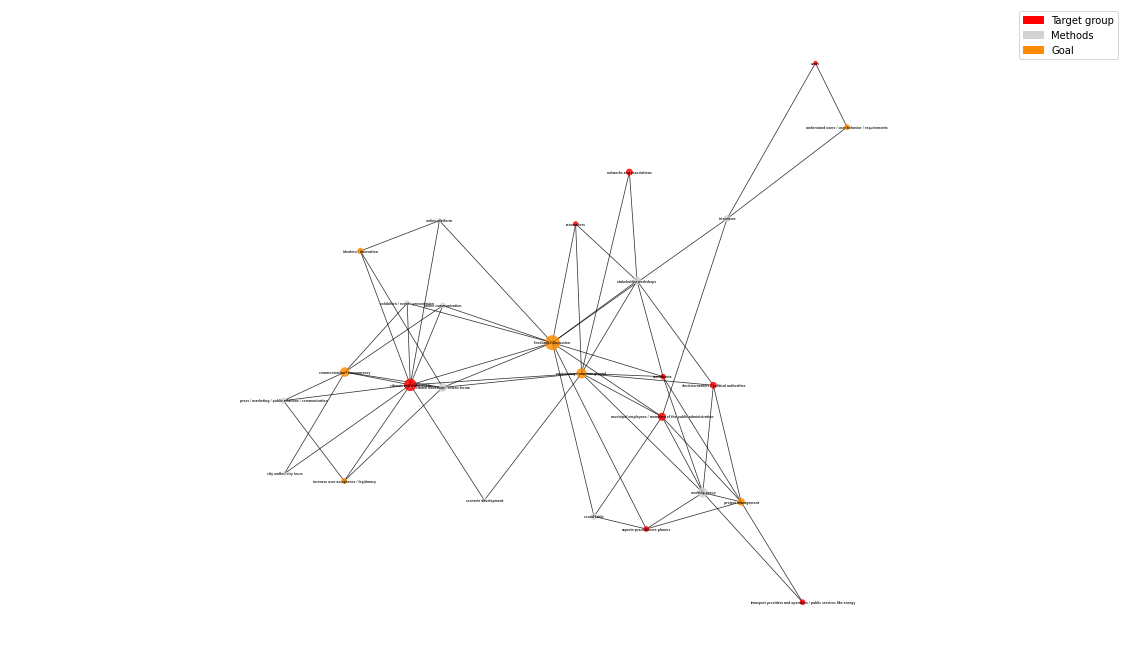

In [132]:
# create the network
fig, ax=plt.subplots(figsize=(20,12))
GA=nx.from_pandas_edgelist(associations_df_edgelist,source='Edge_1',target='Edge_2',
                            edge_attr='Rule_n',
                           create_using=nx.Graph())
# align the node order in the graph with the node datagrame
nodes=nodes.set_index('Node')
nodes=nodes.reindex(GA.nodes())
# Specify colors
color_list = nodes["Category_color"].tolist()
size_list = nodes["frequency"].tolist()
# visualize
nx.draw(GA, with_labels=True, node_size=size_list, node_color=color_list, font_size=3, alpha = 0.8, font_weight="bold", width=0.75, pos=nx.spring_layout(GA, k = 0.3*1/np.sqrt(len(GA.nodes())), iterations = 200))

plt.margins(x=0.4)
# add label for node loors
target_group_patch = mpatches.Patch(color='red', label='Target group')
method_patch = mpatches.Patch(color='lightgrey', label='Methods')
goal_patch = mpatches.Patch(color='darkorange', label='Goal')

plt.legend(handles=[target_group_patch, method_patch, goal_patch])
fig1 = plt.gcf()
plt.show()
fig1.savefig('rules_network_SUMP_germany.png')

#### Cluster analysis / community detection

In [120]:
# apply the algorithm to create the communities generator object
communities_generator = community.girvan_newman(GA)

In [121]:
# create list for all, 1st and 2nd level communities
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
communities = sorted(map(sorted, top_level_communities))

In [122]:
# overall n of communities
len(communities)

2

In [123]:
# overall n of 1st level communities
len(top_level_communities)

2

In [124]:
# overall n of 1st level communities
len(next_level_communities)

3

In [125]:
data = [[element, "Cluster-{}".format(ii + 1)] for ii, st in enumerate(next_level_communities) for element in sorted(st)]
print(data)

[['interviews', 'Cluster-1'], ['understand users / user behavior / requirements', 'Cluster-1'], ['users', 'Cluster-1'], ['citizen workshop / citizen forum', 'Cluster-2'], ['citizens and wider public', 'Cluster-2'], ['city walks / city tours', 'Cluster-2'], ['communication / transparency', 'Cluster-2'], ['exhibition / event / presentation', 'Cluster-2'], ['ideation / innovation', 'Cluster-2'], ['increase user acceptance / legitimacy', 'Cluster-2'], ['online communication', 'Cluster-2'], ['online platform', 'Cluster-2'], ['press / marketing / public relations / communication', 'Cluster-2'], ['scenario development', 'Cluster-2'], ['consultants', 'Cluster-3'], ['decision-makers / political authorities', 'Cluster-3'], ['envisioning / common ground', 'Cluster-3'], ['experts-practitioners-planers', 'Cluster-3'], ['feedback / discussion', 'Cluster-3'], ['municipal employees / members of the public administration', 'Cluster-3'], ['networks and associations', 'Cluster-3'], ['project management',

In [126]:
clusters = pd.DataFrame(data=data, columns=['Node', 'Cluster'])
clusters.head(30)

,Node,Cluster
0,interviews,Cluster-1
1,understand users / user behavior / requirements,Cluster-1
2,users,Cluster-1
3,citizen workshop / citizen forum,Cluster-2
4,citizens and wider public,Cluster-2
5,city walks / city tours,Cluster-2
6,communication / transparency,Cluster-2
7,exhibition / event / presentation,Cluster-2
8,ideation / innovation,Cluster-2
9,increase user acceptance / legitimacy,Cluster-2


In [127]:
nodes = nodes.merge(clusters, left_on='Node', right_on='Node')
nodes.head(30)

,Node,Category,Category_color,frequency,Cluster
0,understand users / user behavior / requirements,Goal,darkorange,22,Cluster-1
1,users,Target group,red,12,Cluster-1
2,online platform,Method,lightgrey,15,Cluster-2
3,citizens and wider public,Target group,red,131,Cluster-2
4,increase user acceptance / legitimacy,Goal,darkorange,23,Cluster-2
5,project management,Goal,darkorange,43,Cluster-3
6,working group,Method,lightgrey,83,Cluster-3
7,consultants,Target group,red,21,Cluster-3
8,stakeholder workshops,Method,lightgrey,54,Cluster-3
9,envisioning / common ground,Goal,darkorange,85,Cluster-3


In [128]:
# following the clusters, attribute a color
nodes["Color_Cluster"] = np.where(nodes["Cluster"] == "Cluster-1", "tab:green",
                             (np.where(nodes["Cluster"] == "Cluster-2", "tab:blue",
                                       (np.where(nodes["Cluster"] == "Cluster-3", "tab:red", 'Other')))))
nodes.head(30)

,Node,Category,Category_color,frequency,Cluster,Color_Cluster
0,understand users / user behavior / requirements,Goal,darkorange,22,Cluster-1,tab:green
1,users,Target group,red,12,Cluster-1,tab:green
2,online platform,Method,lightgrey,15,Cluster-2,tab:blue
3,citizens and wider public,Target group,red,131,Cluster-2,tab:blue
4,increase user acceptance / legitimacy,Goal,darkorange,23,Cluster-2,tab:blue
5,project management,Goal,darkorange,43,Cluster-3,tab:red
6,working group,Method,lightgrey,83,Cluster-3,tab:red
7,consultants,Target group,red,21,Cluster-3,tab:red
8,stakeholder workshops,Method,lightgrey,54,Cluster-3,tab:red
9,envisioning / common ground,Goal,darkorange,85,Cluster-3,tab:red


In [129]:
# create nodelists by category
relevant_target_groups = nodes[nodes['Category']=="Target group"]['Node'].tolist()
relevant_methods = nodes[nodes['Category']=="Method"]['Node'].tolist()
relevant_goals = nodes[nodes['Category']=="Goal"]['Node'].tolist()

In [130]:
# Specify colors
target_groups_colors = nodes[nodes['Category']=="Target group"]['Color_Cluster'].tolist()
methods_colors = nodes[nodes['Category']=="Method"]['Color_Cluster'].tolist()
goals_colors = nodes[nodes['Category']=="Goal"]['Color_Cluster'].tolist()

In [131]:
# Specify sizes
target_groups_size = nodes[nodes['Category']=="Target group"]['frequency'].tolist()
methods_size = nodes[nodes['Category']=="Method"]['frequency'].tolist()
goals_size = nodes[nodes['Category']=="Goal"]['frequency'].tolist()

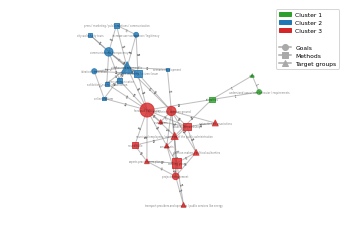

In [139]:
# create the newtork and save node position
nodePos = nx.layout.spring_layout(GA, k = 0.3*1/np.sqrt(len(GA.nodes())), iterations = 300)

# function to filter the dictionnary of node/position by nodelists
dict_filter = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
# apply the function
target_groups_pos=dict_filter(nodePos, relevant_target_groups)
methods_pos=dict_filter(nodePos, relevant_methods)
goals_pos=dict_filter(nodePos, relevant_goals)

# draw nodes for the three categories
nx.draw_networkx_nodes(GA, target_groups_pos, nodelist=relevant_target_groups, node_color=target_groups_colors,
                       alpha = 0.8, node_shape='^', node_size=target_groups_size)
nx.draw_networkx_nodes(GA, methods_pos, nodelist=relevant_methods, node_color=methods_colors, 
                       alpha = 0.8, node_shape='s', node_size=methods_size)
nx.draw_networkx_nodes(GA, goals_pos, nodelist=relevant_goals, node_color=goals_colors, 
                       alpha = 0.8, node_shape='o', node_size=goals_size)

# draaw edge labels
edge_labels = nx.get_edge_attributes(GA, "Rule_n")
nx.draw_networkx_edge_labels(GA, nodePos, edge_labels, font_size = 2.5, font_color = "black")

nx.draw(GA, nodePos, node_size = 0, with_labels=True, font_size=2.5,  alpha=0.5, edge_color="tab:grey", width=1)
plt.margins(x=0.4)
# add legend for shape and colors
legend_elements = [Patch(facecolor='tab:green', edgecolor='tab:green',
                         label='Cluster 1'),
                   Patch(facecolor='tab:blue', edgecolor='tab:blue',
                        label='Cluster 2'),
                   Patch(facecolor='tab:red', edgecolor='tab:red',
                         label='Cluster 3'),
                   Line2D([0], [0], marker='^', color='white', markersize=3, 
                         label=''),
                   Line2D([0], [0], marker='o', color='darkgrey', markersize=6, 
                         label='Goals'),
                   Line2D([0], [0], marker='s', color='darkgrey', markersize=6, 
                         label='Methods'),
                   Line2D([0], [0], marker='^', color='darkgrey', markersize=6, 
                         label='Target groups')]
plt.legend(handles=legend_elements, loc='upper right', prop = {'size' : 6})
fig1 = plt.gcf()
plt.show()
fig1.savefig('rules_network_SUMP_germany_clusters_and_categories2.png', dpi = 3600)